<a href="https://colab.research.google.com/github/pdemeulenaer/intro-to-rag/blob/main/langchain_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copied from https://www.youtube.com/watch?v=uLrReyH5cu0&ab_channel=AlejandroAO-Software%26Ai

# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [ ]:
# for linux
# %sudo apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# %brew install poppler tesseract libmagic

In [1]:
# %pip install -Uq "unstructured[all-docs]" pillow lxml pillow
# %pip install -Uq chromadb tiktoken
# %pip install -Uq langchain langchain-community langchain-openai langchain-groq
# %pip install -Uq python_dotenv


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# import os

# # keys for the services we will use

# os.environ["OPENAI_API_KEY"] = "sk-..." 
# os.environ["GROQ_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

# os.environ["GROQ_API_KEY"]


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [4]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = output_path + 'attention.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

/home/philippe/.cache/pypoetry/virtualenvs/intro-to-rag-vf99OxW6-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
len(chunks)

12

In [6]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [7]:
chunks[3].to_dict()

{'type': 'CompositeElement',
 'element_id': 'a6ce81cc1dae5a636540178efcefa710',
 'text': '3.2 Attention\n\nAn attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum\n\n3\n\nScaled Dot-Product Attention\n\nMulti-Head Attention\n\nLinear\n\nFigure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.\n\nof the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.\n\n3.2.1 Scaled Dot-Product Attention\n\nWe call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.\n

In [8]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [9]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'dc6d9848-5874-4dc2-b186-073a176ff00a',
 'text': '',
 'metadata': {'coordinates': {'points': ((486.0, 261.1805555555558),
    (486.0, 614.7805555555556),
    (664.0, 614.7805555555556),
    (664.0, 261.1805555555558)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-03-07T13:49:31',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQE

### Separate extracted elements into tables, text, and images

In [10]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [11]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

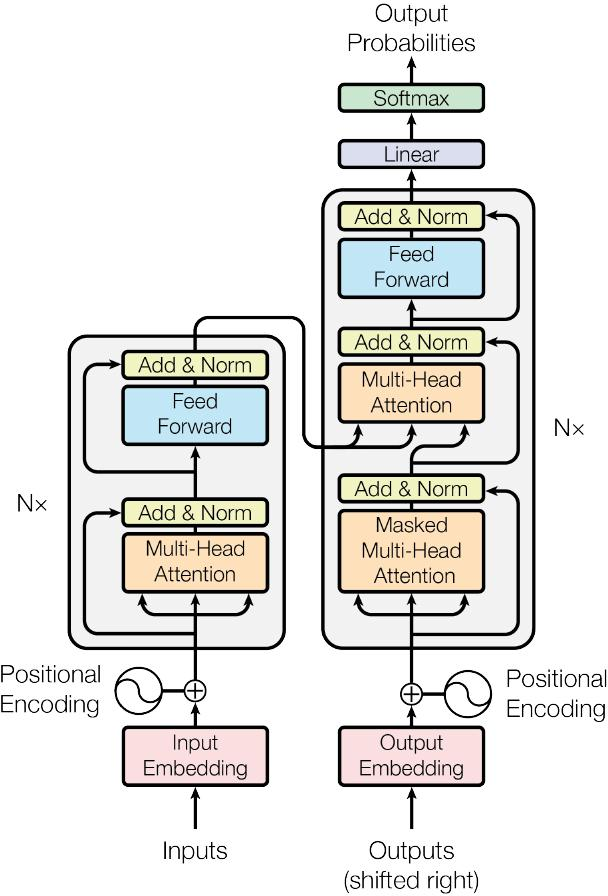

In [12]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [13]:
# %pip install -Uq langchain-groq

In [14]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [15]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [16]:
tables

[]

In [19]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [ ]:
text_summaries

['The paper "Attention Is All You Need" by Ashish Vaswani et al. introduces the Transformer model, a new network architecture based on attention mechanisms, replacing traditional encoder-decoder models. The Transformer achieves state-of-the-art results on two machine translation tasks, improving over existing best results, and generalizes well to other tasks, such as English constituency parsing.',
 'Recurrent neural networks have been established as state of the art in sequence modeling and transduction problems, but their sequential nature limits parallelization and requires computational efficiency improvements through factorization tricks and conditional computation. Attention mechanisms have improved sequence modeling, but typically require a recurrent network. The Transformer model proposes to use attention mechanisms entirely, eschewing recurrence and allowing for more parallelization and improved translation quality.',
 'The Transformer model has an encoder-decoder structure, w

In [20]:
table_summaries

[]

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [21]:
# %pip install -Uq langchain_openai

In [22]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
image_summaries

['The image presents a schematic representation of the transformer architecture, which is fundamental in natural language processing and machine learning. Here’s a detailed description of its components:\n\n1. **Overall Structure**: The diagram is divided into two main sections, representing the encoder (on the left) and the decoder (on the right) of the transformer model. Both sections involve repeated layers denoted as \\(N_x\\), indicating that these layers are stacked multiple times.\n\n2. **Positional Encoding**: At the bottom of both sections, there are blocks labeled "Positional Encoding." This component is crucial as it adds information about the position of tokens in the sequence, enabling the model to understand the order of inputs.\n\n3. **Input and Output Embeddings**: Below the positional encoding blocks, there are two labeled boxes: “Input Embedding” for the encoder and “Output Embedding” for the decoder. These embeddings transform the input tokens into continuous vector 

In [ ]:
print(image_summaries[1])

The image depicts two main concepts from the transformer architecture: **Scaled Dot-Product Attention** and **Multi-Head Attention**.

### Scaled Dot-Product Attention (Left Side)
1. **Structure**: 
   - The flow starts with three inputs represented as **Q** (Query), **K** (Key), and **V** (Value).
   - The first operation is a **MatMul** (matrix multiplication) between Q and K, producing a score.
   - This score is then passed to a **Scale** component, which adjusts the magnitude of the scores.
   - An optional **Mask** is applied next to prevent certain positions from being attended to, often used in tasks like language modeling.
   - The scores are then passed through a **SoftMax** layer to convert them into probabilities.
   - Finally, another **MatMul** operation takes the output from SoftMax and multiplies it by V to produce the final attention output.

### Multi-Head Attention (Right Side)
1. **Structure**:
   - This section builds upon the scaled dot-product attention.
   - It 

## Load data and summaries to vectorstore

### Create the vectorstore

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.document import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/var/folders/lh/7g2mv_x16p79z2rd9jqxqx_w0000gn/T/ipykernel_92745/278287695.py:9: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
/var/folders/lh/7g2mv_x16p79z2rd9jqxqx_w0000gn/T/ipykernel_92745/278287695.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi

### Load the summaries and link the to the original data

In [ ]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [ ]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

[36] Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna. Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.

[37] Vinyals & Kaiser, Koo, Petrov, Sutskever, and Hinton. Grammar as a foreign language. In Advances in Neural Information Processing Systems, 2015.

[38] Yonghui Wu, Mike Schuster, Zhifeng Chen, Quoc V Le, Mohammad Norouzi, Wolfgang Macherey, Maxim Krikun, Yuan Cao, Qin Gao, Klaus Macherey, et al. Google’s neural machine translation system: Bridging the gap between human and machine translation. arXiv preprint arXiv:1609.08144, 2016.

[39] Jie Zhou, Ying Cao, Xuguang Wang, Peng Li, and Wei Xu. Deep recurrent models with fast-forward connections for neural machine translation. CoRR, abs/1606.04199, 2016.

[40] Muhua Zhu, Yue Zhang, Wenliang Chen, Min Zhang, and Jingbo Zhu. Fast and accurate shift-reduce constituent parsing. In Proceedings of the 51st Annual Meeting of the ACL (Volume 1: Long Papers), pages

## RAG pipeline

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [ ]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)

The attention mechanism is a function that maps a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, with the weights determined by a compatibility function that measures how well the query aligns with each key.

In mathematical terms, the attention function can be expressed as:

\[ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V \]

Here, \(Q\) represents the queries, \(K\) the keys, and \(V\) the values. The dot products of the queries and keys are scaled by the square root of the dimension of the keys (\(d_k\)) to prevent large values that could push the softmax function into regions with small gradients. This attention mechanism allows the model to focus on different parts of the input sequence when producing an output, enhancing its ability to handle dependencies and context within the data. 

Additionally, multi-head attention extends th

Response: Multi-head attention is a mechanism used in the Transformer model that allows the model to focus on different parts of the input sequence simultaneously. Instead of using a single attention function, multi-head attention uses multiple attention heads, each performing attention with different, learned linear projections of the queries, keys, and values. 

Here's a breakdown of how it works:

1. **Linear Projections**: The queries (Q), keys (K), and values (V) are projected into different subspaces using learned linear transformations. Each head has its own set of projections.

2. **Parallel Attention**: Each head computes attention independently, allowing the model to attend to various representation subspaces from different positions in the input sequence.

3. **Concatenation**: The outputs from all heads are concatenated together.

4. **Final Linear Projection**: The concatenated output is then projected again to produce the final output.

This approach enables the model to 

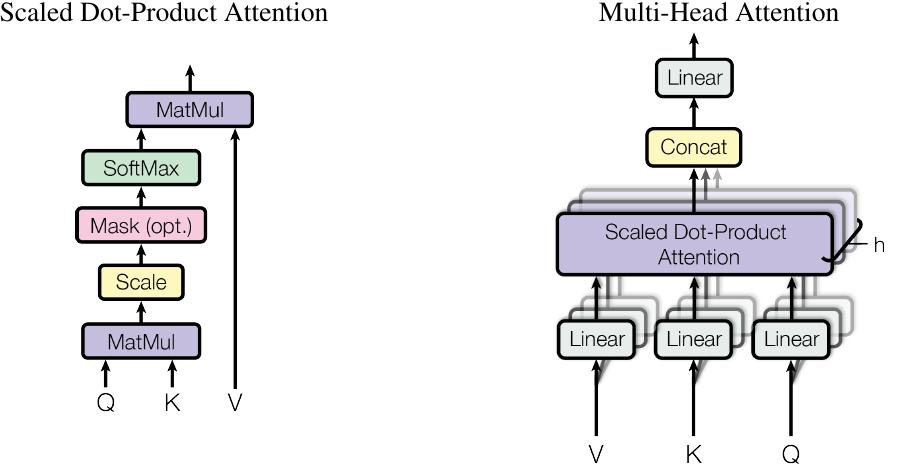

In [ ]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)